In [1]:
import requests
import pandas as pd
import numpy
from sklearn import tree
import graphviz

In [2]:
import grpc
import os
import sys
sys.path.insert(0, os.path.abspath('./lib'))
import testdata_pb2
import testdata_pb2_grpc

channel = grpc.insecure_channel('localhost:9999')
testdata = testdata_pb2_grpc.TestDataStub(channel)

In [3]:
jobs = list(testdata.ListTestJobs(testdata_pb2.ListTestJobsRequest()))
jobs[123]

name: "kops-grid-calico-rhel7-k17-ko19-containerd/"
bucket: "kubernetes-jenkins"
prefix: "logs/e2e-kops-grid-calico-rhel7-k17-ko19-containerd/"

In [4]:
import time
now = time.time()
min_timestamp = now - 24 * 60 * 60

In [5]:
results = []

for job in jobs:
    runs = testdata.ListTestJobRuns(testdata_pb2.ListTestJobRunsRequest(job=job))
    for run in list(runs):
        try:
            result = testdata.GetTestJobRunResults(testdata_pb2.GetTestJobRunResultsRequest(run=run))
            if result.timestamp > min_timestamp:
                results.append(result)
        except:
            pass
len(results)

_MultiThreadedRendezvous: <_MultiThreadedRendezvous of RPC that terminated with:
	status = StatusCode.UNAVAILABLE
	details = "failed to connect to all addresses"
	debug_error_string = "{"created":"@1620400498.881882135","description":"Failed to pick subchannel","file":"src/core/ext/filters/client_channel/client_channel.cc","file_line":3951,"referenced_errors":[{"created":"@1620400498.881862699","description":"failed to connect to all addresses","file":"src/core/ext/filters/client_channel/lb_policy/pick_first/pick_first.cc","file_line":393,"grpc_status":14}]}"
>

In [128]:
feature_names = []
feature_map = {}

def remove_prefix(text, prefix):
    return text[text.startswith(prefix) and len(prefix):]

def feature_to_key(f):
    k = remove_prefix(f.key, 'test.kops.k8s.io/') + '_' + (f.value or 'default').replace("1.", "1")
    return k

for result in results:
    for f in result.features:
        k = feature_to_key(f)
        if k not in feature_map:
            feature_names.append(k)
            feature_map[k] = len(feature_names) - 1

columns = ['job_name', 'timestamp', 'passed']
columns = columns + feature_names

len(columns)

34

In [129]:
rows = []
for result in results:
    if len(result.features) == 0:
        continue
    row = [0] * len(columns)
    row[0] = result.job_name
    row[1] = result.timestamp
    row[2] = 1 if (result.passed) else 0
    for f in result.features:
        k = feature_to_key(f)
        row[3 + feature_map[k]] = 1
    rows.append(row)

df = pd.DataFrame(rows, columns=columns)

In [130]:
clf_features = df.drop(['job_name', 'timestamp', 'passed'], axis=1).astype('bool')
clf_features
clf_samples = df.passed.astype('bool')
clf_samples
clf = tree.DecisionTreeClassifier(max_depth=3)
clf = clf.fit(clf_features, clf_samples)
clf

DecisionTreeClassifier(max_depth=3)

In [131]:
r = tree.export_text(clf, feature_names=feature_names)
print(r)

|--- container_runtime_docker <= 0.50
|   |--- networking_flannel <= 0.50
|   |   |--- networking_calico <= 0.50
|   |   |   |--- class: False
|   |   |--- networking_calico >  0.50
|   |   |   |--- class: False
|   |--- networking_flannel >  0.50
|   |   |--- k8s_version_117 <= 0.50
|   |   |   |--- class: True
|   |   |--- k8s_version_117 >  0.50
|   |   |   |--- class: False
|--- container_runtime_docker >  0.50
|   |--- distro_flatcar <= 0.50
|   |   |--- k8s_version_119 <= 0.50
|   |   |   |--- class: True
|   |   |--- k8s_version_119 >  0.50
|   |   |   |--- class: False
|   |--- distro_flatcar >  0.50
|   |   |--- class: False



[Text(193.15384615384616, 190.26, 'container_runtime_docker <= 0.5\ngini = 0.467\nsamples = 167\nvalue = [105, 62]'),
 Text(103.01538461538462, 135.9, 'networking_flannel <= 0.5\ngini = 0.206\nsamples = 77\nvalue = [68, 9]'),
 Text(51.50769230769231, 81.53999999999999, 'networking_calico <= 0.5\ngini = 0.119\nsamples = 63\nvalue = [59, 4]'),
 Text(25.753846153846155, 27.180000000000007, 'gini = 0.043\nsamples = 46\nvalue = [45, 1]'),
 Text(77.26153846153846, 27.180000000000007, 'gini = 0.291\nsamples = 17\nvalue = [14, 3]'),
 Text(154.52307692307693, 81.53999999999999, 'k8s_version_117 <= 0.5\ngini = 0.459\nsamples = 14\nvalue = [9, 5]'),
 Text(128.76923076923077, 27.180000000000007, 'gini = 0.494\nsamples = 9\nvalue = [4, 5]'),
 Text(180.27692307692308, 27.180000000000007, 'gini = 0.0\nsamples = 5\nvalue = [5, 0]'),
 Text(283.2923076923077, 135.9, 'distro_flatcar <= 0.5\ngini = 0.484\nsamples = 90\nvalue = [37, 53]'),
 Text(257.53846153846155, 81.53999999999999, 'k8s_version_119 <= 0.

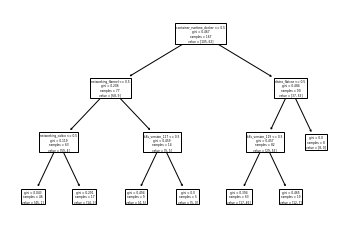

In [132]:
tree.plot_tree(clf, feature_names=feature_names)

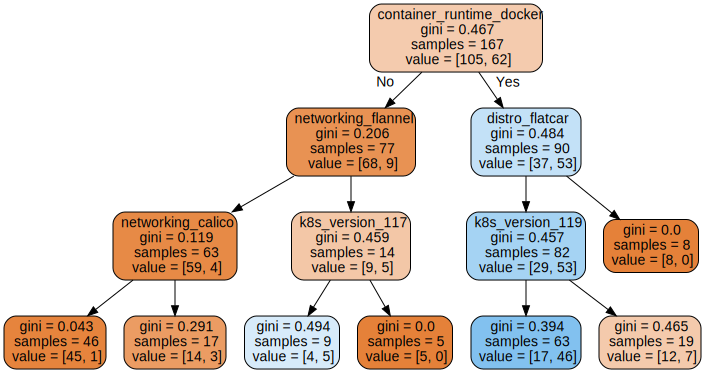

In [133]:
dot_data = tree.export_graphviz(clf, out_file=None, feature_names=feature_names,  filled=True, rounded=True,  special_characters=True)
#dot_data = dot_data.replace("#e58139", "red")
#dot_data = dot_data.replace("#399de5", "green")
dot_data = dot_data.replace("True", "No")
dot_data = dot_data.replace("False", "Yes")
dot_data = dot_data.replace(" &le; 0.5", "")
graph = graphviz.Source(dot_data)
graph
#dot_data

In [137]:
df[df.networking_calico==1]

,job_name,timestamp,passed,kops_channel_alpha,kops_version_default,container_runtime_docker,distro_amzn2,cloud_aws,networking_default,k8s_version_117,...,networking_cilium,networking_flannel,networking_kopeio,extra_flags_--node-size=m6g.large --master-size=m6g.large --image=099720109477/ubuntu/images/hvm-ssd/ubuntu-focal-20.04-arm64-server-20210106,kops_zones_us-east-2b,k8s_version_latest,"feature_flags_EnableExternalCloudController,SpecOverrideFlag",extra_flags_--override=cluster.spec.cloudControllerManager.cloudProvider=aws --override=cluster.spec.cloudConfig.awsEBSCSIDriver.enabled=true,extra_flags_--api-loadbalancer-type=public,"feature_flags_UseServiceAccountIAM,PublicJWKS"
3,kops-grid-calico-amzn2-k17-containerd/,1613216651,0,1,1,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,kops-grid-calico-amzn2-k17-docker/,1613238779,1,1,1,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
5,kops-grid-calico-amzn2-k18-docker/,1613166401,1,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6,kops-grid-calico-amzn2-k18-ko19-docker/,1613163307,0,1,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
7,kops-grid-calico-amzn2-k19-docker/,1613188534,0,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
8,kops-grid-calico-deb10-k18-docker/,1613171288,0,1,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
9,kops-grid-calico-deb10-k19-containerd/,1613165821,1,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
10,kops-grid-calico-deb9-k17-docker/,1613201221,1,1,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
11,kops-grid-calico-deb9-k17-ko19-containerd/,1613226168,0,1,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
12,kops-grid-calico-deb9-k19-ko19-containerd/,1613179334,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
